In [36]:
from keras.layers import Input, Dense, Flatten, Reshape, Dropout
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.models import Model
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
trainfile = 'train.json'
testfile = 'test.json'
encoder_weights = 'encoder_weights.hdf5'
decoder_weights = 'decoder_weights.hdf5'
autoencoder_weights = 'autoencoder_weights.hdf5'
model_weights = 'model_weights.hdf5'

In [3]:
def float_or_na(value):
    return float(value if value != 'na' else 0)

In [58]:
def load(in_path, include_targets=True):
    
    out_df = pd.read_json(in_path)
    out_images = out_df.apply(lambda c_row: [np.stack([c_row['band_1'],c_row['band_2']], -1).reshape((75,75,2))],1)
    out_images = np.stack(out_images).squeeze()
    out_df['inc_angle'] = out_df['inc_angle'].replace('na','nan').astype('float')
    out_df['angle_sin'] = np.sin(out_df['inc_angle'])
    out_df['angle_cos'] = np.cos(out_df['inc_angle'])
    out_angles = out_df.as_matrix(['inc_angle','angle_sin','angle_cos'])
    targets = None
    if(include_targets):
        targets = out_df['is_iceberg'].as_matrix()
    result = (out_df['id'].as_matrix(), out_images, out_angles,targets)
    del out_df
    return result

In [5]:
def normalize(train,test):
    train_min = train.min(axis=(0,1,2), keepdims=True)
    train_max = train.max(axis=(0,1,2), keepdims=True)
    test_min = test.min(axis=(0,1,2), keepdims=True)
    test_max = test.max(axis=(0,1,2), keepdims=True)
    
    x_min = np.minimum(train_min,test_min)
    x_max = np.maximum(train_max,test_max)
    return (train - x_min)/(x_max - x_min), (test - x_min)/(x_max - x_min)

In [6]:
def resize(x):
    for i in range(5):
        x = np.insert(x, 75, 0, axis=1)
        x = np.insert(x, 75, 0, axis=2)
    return x

In [7]:
_, X_train,X_train_angle, y_train = load(trainfile)
test_ids, X_test, X_test_angle, _ = load(testfile,include_targets=False)

In [8]:
X_train, X_test = normalize(X_train, X_test)

In [10]:
X_test = resize(X_test)
X_train = resize(X_train)
X = np.vstack((X_train,X_test))
X.shape

In [11]:
X_test.shape

(8424, 80, 80, 2)

In [14]:
def conv_chain(input_tensor,conv_units, direct_type):
    tensor  = input_tensor
    tensor = Conv2D(conv_units,(3, 3), activation='relu', padding='same')(tensor)
    if(direct_type == 'down'):
        tensor = MaxPooling2D(padding='same')(tensor)
    elif(direct_type == 'up'):
        tensor = UpSampling2D((2, 2))(tensor)
    else:
        raise ValueError('direct_type value is incorrect')
    tensor = Dropout(0.2)(tensor)
    return tensor

In [15]:
bn_model = 0
def create_deep_conv_ae(rows,cols):
    input_img = Input(shape=(rows, cols, 2))
    x = conv_chain(input_img,16,direct_type='down')
    x = conv_chain(x,32,direct_type='down')
    x = conv_chain(x,64,direct_type='down')
    encoded = conv_chain(x,128,direct_type='down')
    
    # at this point the representation is (5, 5, 128)
    input_encoded = Input(shape=(5, 5, 128))
    x = conv_chain(input_encoded,128,direct_type='up')
    x = conv_chain(x,64,direct_type='up')
    x = conv_chain(x,32,direct_type='up')
    x = conv_chain(x,16,direct_type='up')
    decoded = Conv2D(2, (3, 3), activation='sigmoid', padding='same')(x)
    
    # models
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

In [16]:
encoder, decoder, autoencoder = create_deep_conv_ae(80,80)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 80, 2)         0         
_________________________________________________________________
encoder (Model)              (None, 5, 5, 128)         97296     
_________________________________________________________________
decoder (Model)              (None, 80, 80, 2)         244754    
Total params: 342,050
Trainable params: 342,050
Non-trainable params: 0
_________________________________________________________________


In [17]:
autoencoder.fit(X, X,
                epochs=1,
                batch_size=32,
                shuffle=True,
                validation_split=0.2)

Train on 8022 samples, validate on 2006 samples
Epoch 1/1
8022/8022 [==============================] - 287s - loss: 0.5436 - val_loss: 0.5314


In [18]:
encoder.save_weights(encoder_weights)
decoder.save_weights(decoder_weights)
autoencoder.save_weights(autoencoder_weights)

In [19]:
del X

In [48]:
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

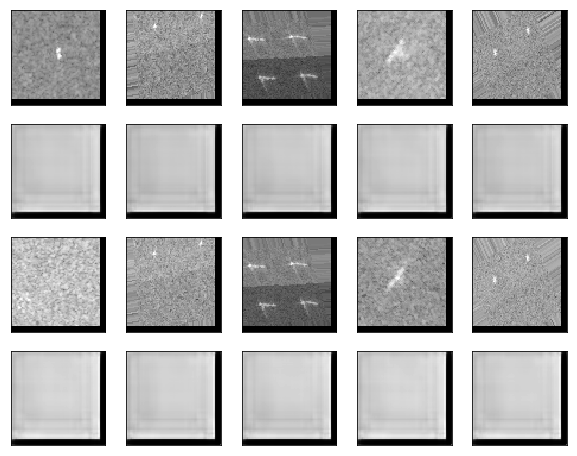

In [50]:
n = 5
imgs = X_test[:n]
encoded_imgs = encoder.predict(imgs, batch_size=n)
decoded_imgs = decoder.predict(encoded_imgs, batch_size=n)
plot_digits(imgs[:,:,:,0], decoded_imgs[:,:,:,0],imgs[:,:,:,1],decoded_imgs[:,:,:,1])

In [ ]:
def get_callbacks(filepath, patience=2,use_tensorboad=False):
    cb= []
    cb.append(EarlyStopping('val_loss', patience=patience, mode="min"))
    cb.append(ModelCheckpoint(filepath, save_best_only=True))
    if(use_tensorboad):
        cb.append(TensorBoard(log_dir='Graph', histogram_freq=0, write_graph=True, write_images=True))
        if(os.path.isdir("Graph")):
            shutil.rmtree('Graph')
    return cb

In [52]:
bn_model = 0
img_input = Input(shape=(80,80,2), name='image')
img_encoded = encoder(img_input)
img_encoded = GlobalMaxPooling2D()(img_encoded)

angle_input = Input(shape=(X_angle.shape[1], ), name='angle')


classification = concatenate([img_encoded, BatchNormalization(momentum=bn_model)(angle_input)])
classification = Dense(256, activation = 'relu')(classification)
classification =  Dropout(0.2)(classification)
classification =  Dense(1, activation = 'sigmoid')(classification)
model = Model([img_input,angle_input], classification)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
image (InputLayer)               (None, 80, 80, 2)     0                                            
____________________________________________________________________________________________________
encoder (Model)                  (None, 5, 5, 128)     97296       image[0][0]                      
____________________________________________________________________________________________________
angle (InputLayer)               (None, 3)             0                                            
____________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalMa (None, 128)           0           encoder[2][0]                    
___________________________________________________________________________________________

In [54]:
model.fit([X_train,X_angle], y,
          batch_size=32,
          epochs=5, 
          validation_split=0.2,   
          verbose=1)

NameError: name 'y' is not defined